# Original Copyright notice
Copyright (c) 2018, Miguel Morales
All rights reserved.

Redistribution and use in source and binary forms, with or without
modification, are permitted provided that the following conditions are met:

* Redistributions of source code must retain the above copyright notice, this
  list of conditions and the following disclaimer.

* Redistributions in binary form must reproduce the above copyright notice,
  this list of conditions and the following disclaimer in the documentation
  and/or other materials provided with the distribution.

* Neither the name of the copyright holder nor the names of its
  contributors may be used to endorse or promote products derived from
  this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY THE COPYRIGHT HOLDERS AND CONTRIBUTORS "AS IS"
AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE
IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE
DISCLAIMED. IN NO EVENT SHALL THE COPYRIGHT HOLDER OR CONTRIBUTORS BE LIABLE
FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL
DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR
SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER
CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY,
OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE
OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

## Original URL
[Chapter 8 notebook](https://github.com/mimoralea/gdrl/blob/master/notebooks/chapter_08/chapter-08.ipynb)

# NFQ

In [1]:
!nvidia-smi

Sat Jun  7 17:28:51 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 570.153.02             Driver Version: 570.153.02     CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...    Off |   00000000:01:00.0 Off |                  N/A |
| N/A   44C    P0             10W /   35W |      14MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
# Hack to load the gym_walk and gym_aima modules
import sys
import os
   
sys.path.append(os.path.abspath('../../../'))

In [3]:
import warnings ; warnings.filterwarnings('ignore')
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
from IPython.display import display
from collections import namedtuple, deque
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
from itertools import cycle, count
from textwrap import wrap

import matplotlib
import subprocess
import os.path
import tempfile
import random
import base64
import pprint
import glob
import time
import json
import sys
import gymnasium as gym
import io
import os
import gc

from gymnasium import wrappers
from subprocess import check_output
from IPython.display import HTML

%matplotlib inline

In [4]:
plt.style.use('fivethirtyeight')
params = {
    'figure.figsize': (15, 8),
    'font.size': 24,
    'legend.fontsize': 20,
    'axes.titlesize': 28,
    'axes.labelsize': 24,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20
}
pylab.rcParams.update(params)
np.set_printoptions(suppress=True)

In [5]:
torch.cuda.is_available()

True

# NFQ

In [6]:
from src.gdrl.ch8 import FCQ, EGreedyStrategy,GreedyStrategy, NFQ, BEEP
from src.gdrl.ch8.env_utils import get_make_env_fn

In [7]:
SEEDS = (12, 34, 56, 78, 90)

nfq_results = []
best_agent, best_eval_score = None, float('-inf')
for seed in SEEDS:
    environment_settings = {
        'env_name': 'CartPole-v1',
        'gamma': 1.00,
        'max_minutes': 20,
        'max_episodes': 100,
        'goal_mean_100_reward': 475
    }
    
    value_model_fn = lambda nS, nA: FCQ(nS, nA, hidden_dims=(512,128))
    # value_optimizer_fn = lambda net, lr: optim.Adam(net.parameters(), lr=lr)
    value_optimizer_fn = lambda net, lr: optim.RMSprop(net.parameters(), lr=lr)
    value_optimizer_lr = 0.0005

    training_strategy_fn = lambda: EGreedyStrategy(epsilon=0.5)
    # evaluation_strategy_fn = lambda: EGreedyStrategy(epsilon=0.05)
    evaluation_strategy_fn = lambda: GreedyStrategy()

    batch_size = 1024
    epochs = 4

    env_name, gamma, max_minutes, \
    max_episodes, goal_mean_100_reward = environment_settings.values()
    agent = NFQ(value_model_fn, 
                value_optimizer_fn, 
                value_optimizer_lr,
                training_strategy_fn,
                evaluation_strategy_fn,
                batch_size,
                epochs)

    # make_env_fn, make_env_kargs = get_make_env_fn(
    #     env_name=env_name, addon_wrappers=[DiscountedCartPole,])
    make_env_fn, make_env_kargs = get_make_env_fn(env_name=env_name)
    result, final_eval_score, training_time, wallclock_time = agent.train(
        make_env_fn, make_env_kargs, seed, gamma, max_minutes, max_episodes, goal_mean_100_reward)
    nfq_results.append(result)
    if final_eval_score > best_eval_score:
        best_eval_score = final_eval_score
        best_agent = agent
nfq_results = np.array(nfq_results)
_ = BEEP()

render_mode: None
el 00:00:01, ep 0000, ts 000011, ar 10 011.0±000.0, 100 011.0±000.0, ex 100 0.3±0.0, ev 010.0±000.0
el 00:00:12, ep 0099, ts 001315, ar 10 013.2±005.0, 100 013.2±003.9, ex 100 0.2±0.1, ev 009.4±000.7
--> reached_max_episodes ✕
Training complete.
Final evaluation score 9.34±0.78 in 10.83s training time, 12.56s wall-clock time.

render_mode: None
el 00:00:00, ep 0000, ts 000011, ar 10 011.0±000.0, 100 011.0±000.0, ex 100 0.3±0.0, ev 009.0±000.0
el 00:00:10, ep 0099, ts 001386, ar 10 013.2±003.4, 100 013.9±005.4, ex 100 0.2±0.1, ev 009.3±000.8
--> reached_max_episodes ✕
Training complete.
Final evaluation score 9.32±0.75 in 10.47s training time, 11.01s wall-clock time.

render_mode: None
el 00:00:00, ep 0000, ts 000012, ar 10 012.0±000.0, 100 012.0±000.0, ex 100 0.2±0.0, ev 009.0±000.0
el 00:00:11, ep 0099, ts 001376, ar 10 016.7±005.4, 100 013.8±004.6, ex 100 0.2±0.1, ev 009.4±000.7
--> reached_max_episodes ✕
Training complete.
Final evaluation score 9.23±0.77 in 10.79s

INFO:root:Recording videos to: /tmp/gym-video-CartPole-v1-kck4qxky


Created environment 'CartPole-v1' with render mode: rgb_array
render_mode: rgb_array



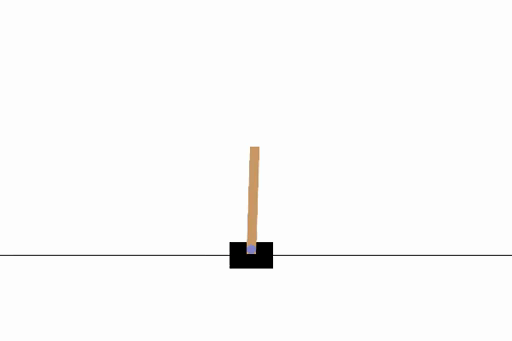
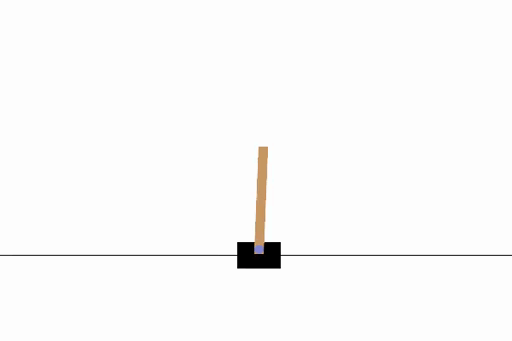
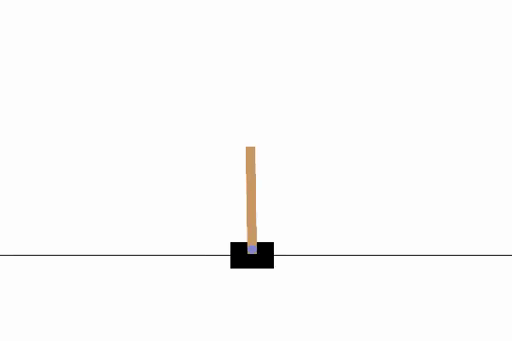
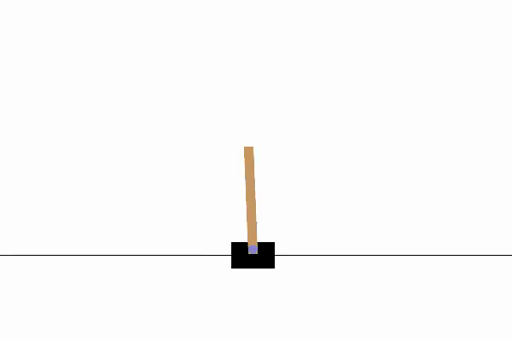
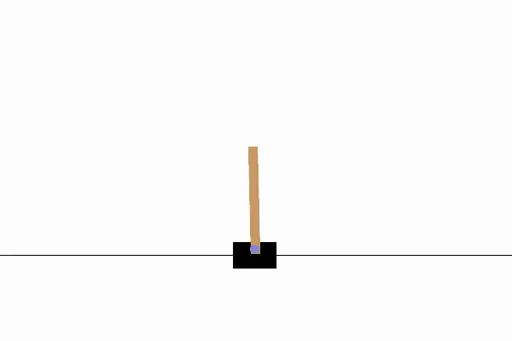

In [8]:
best_agent.demo_progression()

INFO:root:Recording videos to: /tmp/gym-video-CartPole-v1-5aqf8zoy


Created environment 'CartPole-v1' with render mode: rgb_array
render_mode: rgb_array



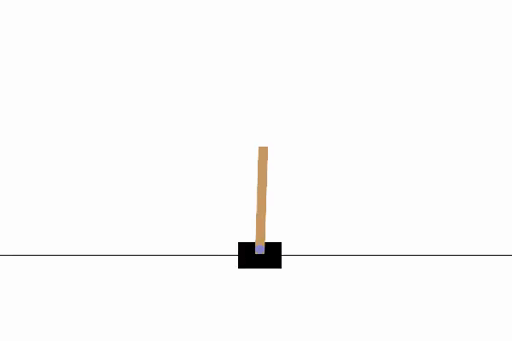
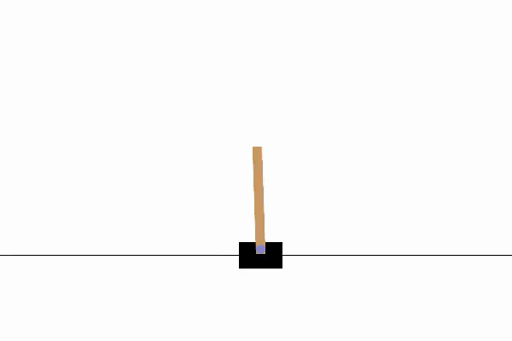

In [9]:
best_agent.demo_last()

In [10]:
nfq_max_t, nfq_max_r, nfq_max_s, \
    nfq_max_sec, nfq_max_rt = np.max(nfq_results, axis=0).T
nfq_min_t, nfq_min_r, nfq_min_s, \
    nfq_min_sec, nfq_min_rt = np.min(nfq_results, axis=0).T
nfq_mean_t, nfq_mean_r, nfq_mean_s, \
    nfq_mean_sec, nfq_mean_rt = np.mean(nfq_results, axis=0).T
nfq_x = np.arange(len(nfq_mean_s))

# nfq_max_t, nfq_max_r, nfq_max_s, \
#     nfq_max_sec, nfq_max_rt = np.nanmax(nfq_results, axis=0).T
# nfq_min_t, nfq_min_r, nfq_min_s, \
#     nfq_min_sec, nfq_min_rt = np.nanmin(nfq_results, axis=0).T
# nfq_mean_t, nfq_mean_r, nfq_mean_s, \
#     nfq_mean_sec, nfq_mean_rt = np.nanmean(nfq_results, axis=0).T
# nfq_x = np.arange(len(nfq_mean_s))

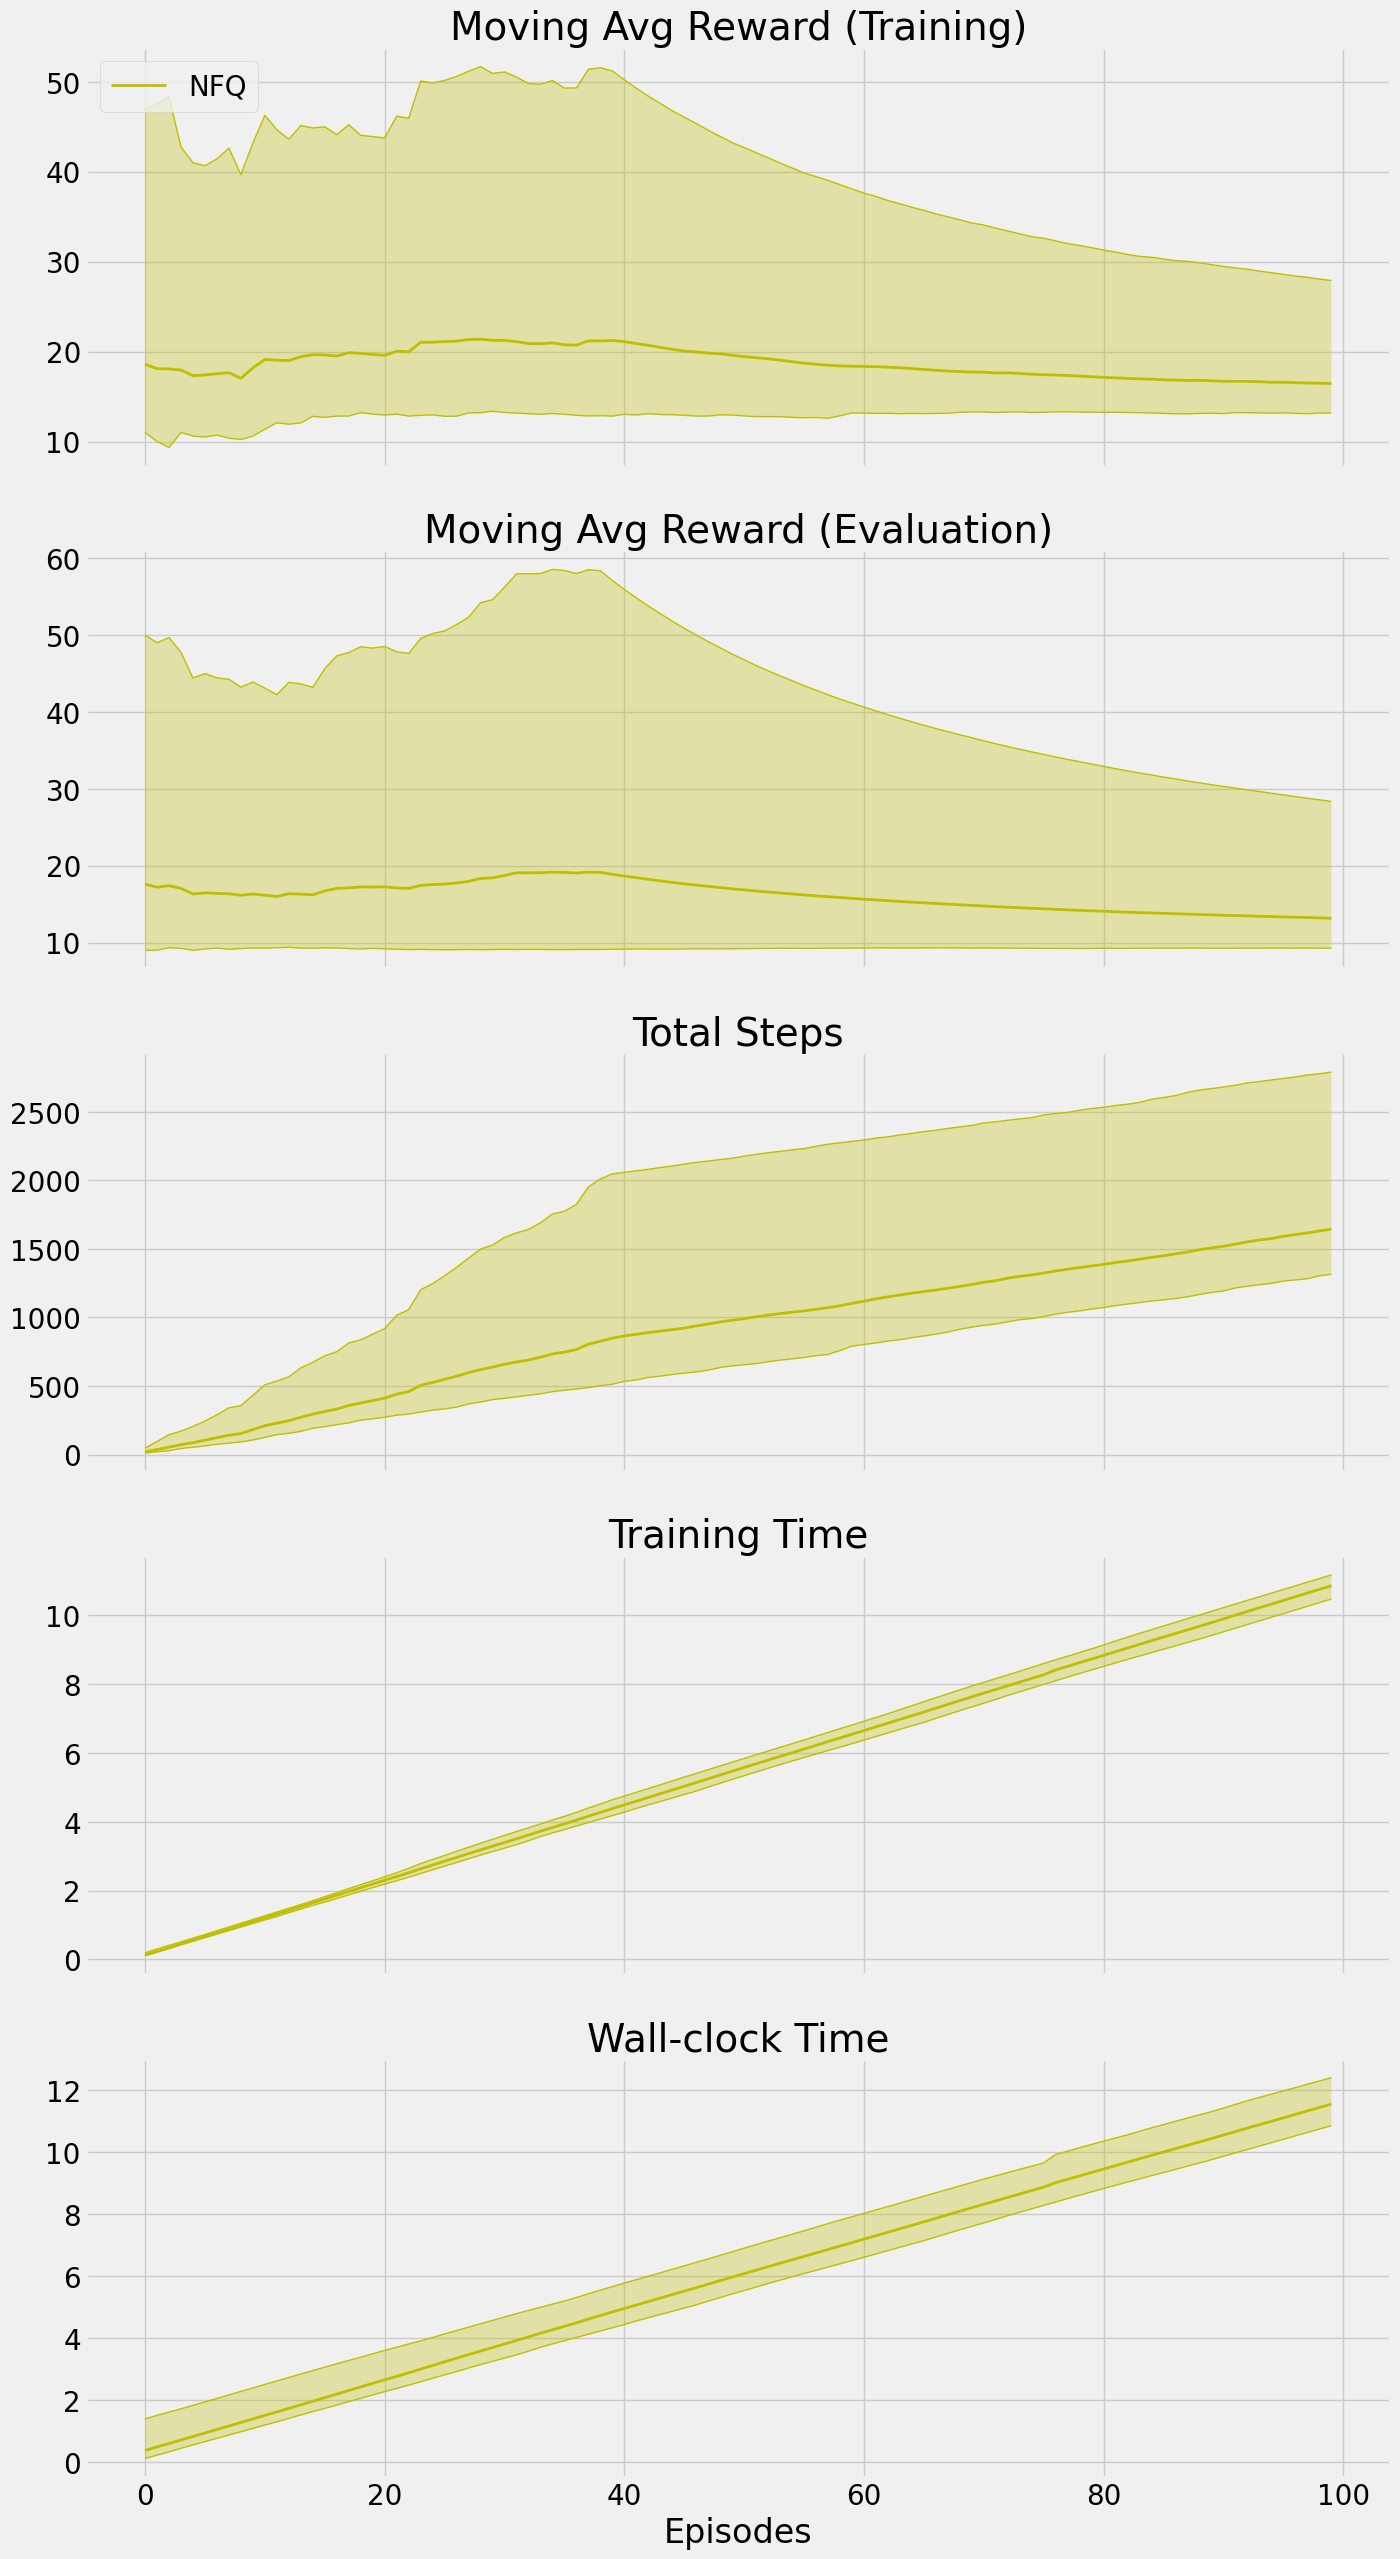

In [11]:
fig, axs = plt.subplots(5, 1, figsize=(15,30), sharey=False, sharex=True)

# NFQ
axs[0].plot(nfq_max_r, 'y', linewidth=1)
axs[0].plot(nfq_min_r, 'y', linewidth=1)
axs[0].plot(nfq_mean_r, 'y', label='NFQ', linewidth=2)
axs[0].fill_between(nfq_x, nfq_min_r, nfq_max_r, facecolor='y', alpha=0.3)

axs[1].plot(nfq_max_s, 'y', linewidth=1)
axs[1].plot(nfq_min_s, 'y', linewidth=1)
axs[1].plot(nfq_mean_s, 'y', label='NFQ', linewidth=2)
axs[1].fill_between(nfq_x, nfq_min_s, nfq_max_s, facecolor='y', alpha=0.3)

axs[2].plot(nfq_max_t, 'y', linewidth=1)
axs[2].plot(nfq_min_t, 'y', linewidth=1)
axs[2].plot(nfq_mean_t, 'y', label='NFQ', linewidth=2)
axs[2].fill_between(nfq_x, nfq_min_t, nfq_max_t, facecolor='y', alpha=0.3)

axs[3].plot(nfq_max_sec, 'y', linewidth=1)
axs[3].plot(nfq_min_sec, 'y', linewidth=1)
axs[3].plot(nfq_mean_sec, 'y', label='NFQ', linewidth=2)
axs[3].fill_between(nfq_x, nfq_min_sec, nfq_max_sec, facecolor='y', alpha=0.3)

axs[4].plot(nfq_max_rt, 'y', linewidth=1)
axs[4].plot(nfq_min_rt, 'y', linewidth=1)
axs[4].plot(nfq_mean_rt, 'y', label='NFQ', linewidth=2)
axs[4].fill_between(nfq_x, nfq_min_rt, nfq_max_rt, facecolor='y', alpha=0.3)

# ALL
axs[0].set_title('Moving Avg Reward (Training)')
axs[1].set_title('Moving Avg Reward (Evaluation)')
axs[2].set_title('Total Steps')
axs[3].set_title('Training Time')
axs[4].set_title('Wall-clock Time')
plt.xlabel('Episodes')
axs[0].legend(loc='upper left')
plt.show()

In [12]:
nfq_root_dir = os.path.join(RESULTS_DIR, 'nfq')
not os.path.exists(nfq_root_dir) and os.makedirs(nfq_root_dir)

np.save(os.path.join(nfq_root_dir, 'x'), nfq_x)

np.save(os.path.join(nfq_root_dir, 'max_r'), nfq_max_r)
np.save(os.path.join(nfq_root_dir, 'min_r'), nfq_min_r)
np.save(os.path.join(nfq_root_dir, 'mean_r'), nfq_mean_r)

np.save(os.path.join(nfq_root_dir, 'max_s'), nfq_max_s)
np.save(os.path.join(nfq_root_dir, 'min_s'), nfq_min_s )
np.save(os.path.join(nfq_root_dir, 'mean_s'), nfq_mean_s)

np.save(os.path.join(nfq_root_dir, 'max_t'), nfq_max_t)
np.save(os.path.join(nfq_root_dir, 'min_t'), nfq_min_t)
np.save(os.path.join(nfq_root_dir, 'mean_t'), nfq_mean_t)

np.save(os.path.join(nfq_root_dir, 'max_sec'), nfq_max_sec)
np.save(os.path.join(nfq_root_dir, 'min_sec'), nfq_min_sec)
np.save(os.path.join(nfq_root_dir, 'mean_sec'), nfq_mean_sec)

np.save(os.path.join(nfq_root_dir, 'max_rt'), nfq_max_rt)
np.save(os.path.join(nfq_root_dir, 'min_rt'), nfq_min_rt)
np.save(os.path.join(nfq_root_dir, 'mean_rt'), nfq_mean_rt)

NameError: name 'RESULTS_DIR' is not defined